# Multi-Agent Simulations of (Argumentative) Belief Dynamics with LMs

## General settings

In [57]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
import logging
from IPython.display import display, HTML

from datetime import date
import os
import os.path
import matplotlib.pyplot as plt
import ast

from nltk import ngrams

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
from beldynlm import *

In [3]:
import importlib
import beldynlm
importlib.reload(beldynlm)
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Tue Mar 16 09:18:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 29%   29C    P8    13W / 250W |      5MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:5E:00.0 Off |                  Off |
| 33%   

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.__version__

'1.8.0+cu111'

### Model and Tokenizer

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
model.to("cuda")

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [9]:
# test model

input_tensor = (tokenizer(["I am against mandatory voting!","I am against mandatory v!","All for it, too."],padding=True,return_tensors="pt")).to('cuda')

output = model(input_tensor['input_ids'], labels = input_tensor['input_ids'] )

labels = input_tensor['input_ids']
logits = output['logits']

for t in torch.split(labels,1):
    print(t)


tensor([[   40,   716,  1028, 13677,  6709,     0]], device='cuda:0')
tensor([[   40,   716,  1028, 13677,   410,     0]], device='cuda:0')
tensor([[3237,  329,  340,   11, 1165,   13]], device='cuda:0')


### Global parameters 

In [66]:
global_parameters = {
    'topic':'compulsory_voting',
    'n_agents':15,
    'max_t':40,
    'n_initial_posts':5, # number of initial posts, simulation starts at t = n_initial_posts
    'initial_neighb-peer_ratio':.5, # average ratio of neighbors that are initially considered peers
    'context_size':8, # max number of posts that are included in an agents perspective
    'relevance_deprecation':.9, # how much more likely (factor) is it the agents retains a post dating from (t-k-1) than one dating from (t-k)
    'self_confidence':1, # how much more likely (factor) is it the agents retains a post from her own than from a peer 
    'n_gram_prohibition':5, # drop generated sentences as soon as n-gram of this size is repeated 
    'perspective_expansion_method':'random', # 'random' or 'confirmation_bias'
    'conf_bias_exponent':5,
    'peer_selection_method':'bounded_confidence', # 'all_neighbors' or 'bounded_confidence'
    'fwd_batch_size': 20
}

peer_selection_parameters = [
     {
         'id':'all_neighbors'
     },
     {
         'id':'bounded_confidence',
         'epsilon':0.01
     }
#    {
#        'id':'closed_rooms',
#        'by_roomsize': False, # Determine number of rooms by n_agents/agents_per_room
#        'n_rooms':2,
#        'agents_per_room':5
#    }
]



In [67]:
decoding_parameters = {
    'do_sample':True, 
    'num_beams':5,
    'temperature': 1, # 1.3,
    'top_p': 0.5, # 0.99, 
    'top_k':0,
     #'no_repeat_ngram_size':8,
    'repetition_penalty':1.2,
    'max_length':40,
    'bad_words_ids':[[LMUtilitiesMixIn.NEWLINE_TOKENID],[LMUtilitiesMixIn.ETC_TOKENID]]
}

# Listening Agents

## Initialization

In [27]:
conversation = Conversation(global_parameters=global_parameters)
conversation.load_topic('topics/all-drugs-should-be-legalized-7100.json', tokenizer=tokenizer)

agents = []
for i in range(global_parameters['n_agents']):
    agent = ListeningLMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        perspective_expansion_method=global_parameters['perspective_expansion_method'],
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize()

## Loop

In [28]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in agents:
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/35 [00:00<?, ?it/s]

In [29]:
conversation.save(path='', froot='test4', overwrite=True, config=[decoding_parameters])

## Visualize

In [58]:
plot_data = pd.read_csv('test4.csv',index_col=['step','agent'], skipinitialspace=True)
for col in ['perspective', 'peers']:
    plot_data[col] = plot_data[col].apply(lambda s: ast.literal_eval(s))

In [59]:
plot_data.head()

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': "It doesn't mean that ...   
     1      {'type': 'pro', 'text': 'Legalization will hel...   
     2      {'type': 'pro', 'text': "Containers for illega...   
     3      {'type': 'pro', 'text': "[Psychedelics](https:...   
     4      {'type': 'con', 'text': "Currently, obtaining ...   

                                     peers perspective timestamps  polarity  \
step agent                                                                    
0    0         [13, 6, 10, 0, 9, 5, 2, 12]          []         []  0.591557   
     1         [11, 5, 6, 7, 2, 14, 1, 13]          []         []  0.591557   
     2       [13, 6, 1, 10, 5, 8, 9, 7, 2]          []         []  0.591557   
     3         [7, 11, 10, 9, 3, 0, 6, 14]          []         []  0.591557   
     4      [11, 0, 10, 3, 5, 9, 14, 2, 4]          []         []  0.591557   

            salience  
step agent            
0    0      13.73728  
     1      13.73728  
     2      13.73728  
     3      13.73728  
     4      13.73728

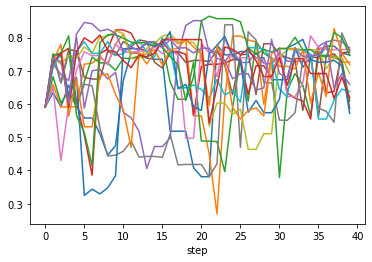

In [60]:
ax = plot_data.polarity.unstack().plot(legend=False)
#ax.legend(loc='upper left', ncol=2)

<AxesSubplot:xlabel='step'>

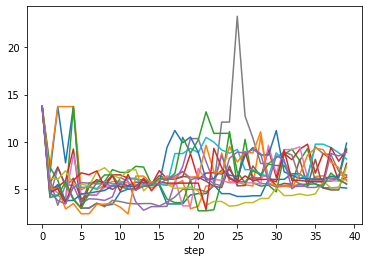

In [61]:
plot_data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

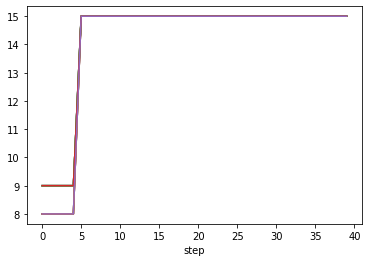

In [62]:
plot_data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

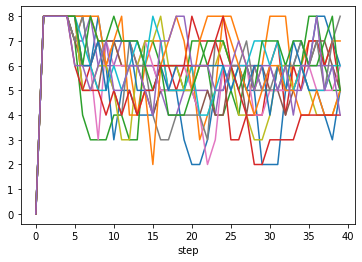

In [63]:
plot_data.perspective.apply(len).unstack().plot(legend=False)

In [64]:
plot_data.timestamps.unstack()

agent,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
step,,,,,,,,,,,,,,,
0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
2,"[1, 0, 0, 0, 0, 1, 0, 1]","[1, 1, 0, 0, 1, 0, 1, 1]","[1, 0, 0, 1, 0, 1, 0, 0]","[1, 1, 1, 0, 0, 1, 0, 0]","[0, 0, 1, 1, 1, 1, 0, 0]","[1, 1, 0, 0, 1, 0, 0, 1]","[1, 0, 0, 1, 1, 1, 0, 1]","[1, 0, 0, 1, 1, 1, 1, 0]","[1, 1, 1, 0, 0, 0, 0, 1]","[1, 0, 1, 1, 0, 0, 1, 0]","[1, 0, 0, 1, 1, 0, 1, 0]","[0, 1, 1, 0, 0, 0, 1, 1]","[1, 0, 1, 0, 1, 1, 0, 1]","[0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 1, 1, 0, 1, 1, 0]"
3,"[2, 2, 2, 2, 0, 1, 2, 0]","[1, 0, 1, 1, 2, 1, 1, 2]","[1, 2, 0, 1, 0, 1, 0, 2]","[2, 1, 2, 2, 2, 2, 0, 0]","[1, 0, 1, 2, 0, 0, 2, 0]","[2, 2, 1, 1, 2, 0, 1, 0]","[1, 2, 0, 0, 0, 2, 1, 1]","[0, 1, 2, 0, 1, 0, 2, 1]","[1, 0, 2, 1, 1, 2, 0, 0]","[2, 0, 1, 2, 2, 2, 1, 2]","[1, 0, 2, 0, 2, 1, 0, 2]","[0, 0, 0, 2, 0, 2, 2, 2]","[0, 2, 2, 0, 2, 2, 0, 0]","[2, 0, 1, 0, 2, 1, 2, 0]","[1, 0, 0, 1, 0, 1, 0, 0]"
4,"[1, 2, 2, 0, 1, 1, 1, 0]","[0, 2, 2, 1, 3, 1, 1, 0]","[0, 1, 2, 2, 1, 2, 2, 3]","[0, 3, 2, 1, 1, 1, 2, 3]","[2, 1, 2, 0, 2, 3, 1, 1]","[2, 1, 1, 2, 3, 3, 0, 1]","[3, 3, 2, 3, 0, 1, 3, 1]","[2, 1, 1, 3, 3, 2, 2, 3]","[0, 3, 2, 0, 3, 1, 1, 3]","[1, 0, 2, 2, 0, 1, 0, 2]","[3, 2, 2, 0, 3, 1, 3, 1]","[1, 1, 3, 3, 0, 3, 0, 3]","[3, 0, 2, 2, 2, 1, 3, 2]","[3, 1, 3, 0, 2, 2, 2, 1]","[2, 1, 0, 1, 1, 3, 2, 3]"
5,"[1, 2, 2, 1, 1, 0, 5, 5]","[0, 2, 2, 1, 3, 1, 0]","[1, 2, 2, 1, 3, 5, 5]","[0, 2, 1, 1, 1, 2, 3, 5]","[2, 1, 2, 2, 3, 1, 5]","[2, 1, 1, 2, 3, 3, 1]","[3, 3, 2, 3, 0, 1, 5, 5]","[2, 1, 1, 3, 2, 3, 5]","[0, 3, 2, 0, 3, 1, 1, 3]","[1, 0, 2, 0, 1, 0, 2, 5]","[3, 2, 0, 3, 1, 3, 5, 5]","[1, 3, 0, 3, 0, 3, 5, 5]","[3, 0, 2, 2, 2, 1, 3, 5]","[3, 3, 2, 2, 1, 5]","[1, 1, 1, 3, 3, 5]"
6,"[1, 2, 2, 1, 1, 0, 5, 5]","[0, 2, 2, 1, 3, 1, 0, 6]","[5, 5, 6, 6]","[2, 1, 2, 5, 6]","[2, 1, 2, 3, 5, 6, 6]","[2, 1, 2, 3, 3, 1]","[3, 2, 3, 1, 5, 5]","[2, 1, 1, 3, 2, 3, 5, 6]","[0, 1, 1, 6, 6]","[2, 0, 0, 2, 5, 6, 6]","[3, 2, 0, 3, 5, 5]","[1, 3, 0, 3, 0, 3, 5, 5]","[2, 2, 3, 5, 6, 6]","[3, 2, 2, 1, 5]","[1, 1, 3, 3, 5, 6]"
7,"[1, 2, 1, 5, 5, 7]","[0, 2, 2, 1, 3, 1, 0, 6]","[5, 6, 6]","[2, 5, 6, 7, 7, 7]","[2, 1, 2, 3, 5, 6, 6, 7]","[2, 1, 2, 3, 3, 1]","[3, 2, 3, 1, 5, 5]","[2, 1, 2, 3, 5, 6]","[1, 1, 6, 6, 7]","[2, 0, 2, 5, 6, 6]","[3, 2, 3, 5, 5, 7]","[1, 0, 3, 0, 3, 5, 5, 7]","[2, 2, 5, 6, 6, 7, 7, 7]","[2, 2, 1, 5, 7]","[1, 3, 5, 6, 7]"
8,"[1, 2, 1, 5, 5, 7, 8, 8]","[2, 2, 1, 3, 1, 0, 6]","[5, 6, 6]","[2, 5, 6, 7, 7, 7, 8]","[1, 3, 5, 6, 6, 7]","[1, 3, 3, 1, 8]","[1, 5, 5]","[2, 1, 2, 3, 5, 8, 8]","[1, 1, 6, 6, 7, 8]","[2, 2, 5, 6, 8]","[3, 2, 3, 5, 5, 7, 8]","[1, 0, 3, 0, 3, 5, 7, 8]","[2, 5, 6, 6, 7, 7, 7]","[2, 2, 5, 7, 8]","[1, 3, 5, 6, 7, 8]"


In [65]:
plot_data.perspective.unstack()

agent,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
step,,,,,,,,,,,,,,,
0,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,"[(0, 13), (0, 6), (0, 10), (0, 0), (0, 9), (0,...","[(0, 11), (0, 5), (0, 6), (0, 7), (0, 2), (0, ...","[(0, 7), (0, 13), (0, 5), (0, 8), (0, 10), (0,...","[(0, 7), (0, 11), (0, 10), (0, 9), (0, 3), (0,...","[(0, 9), (0, 3), (0, 11), (0, 5), (0, 2), (0, ...","[(0, 0), (0, 9), (0, 10), (0, 6), (0, 1), (0, ...","[(0, 4), (0, 11), (0, 1), (0, 12), (0, 10), (0...","[(0, 2), (0, 9), (0, 10), (0, 0), (0, 5), (0, ...","[(0, 11), (0, 9), (0, 0), (0, 8), (0, 14), (0,...","[(0, 3), (0, 10), (0, 4), (0, 2), (0, 14), (0,...","[(0, 0), (0, 8), (0, 6), (0, 10), (0, 4), (0, ...","[(0, 10), (0, 1), (0, 7), (0, 5), (0, 14), (0,...","[(0, 7), (0, 10), (0, 4), (0, 6), (0, 11), (0,...","[(0, 13), (0, 9), (0, 1), (0, 0), (0, 10), (0,...","[(0, 13), (0, 6), (0, 1), (0, 8), (0, 5), (0, ..."
2,"[(1, 6), (0, 5), (0, 12), (0, 6), (0, 9), (1, ...","[(1, 14), (1, 13), (0, 2), (0, 11), (1, 11), (...","[(1, 5), (0, 2), (0, 1), (1, 1), (0, 13), (1, ...","[(1, 7), (1, 14), (1, 11), (0, 3), (0, 0), (1,...","[(0, 2), (0, 11), (1, 14), (1, 11), (1, 5), (1...","[(1, 6), (1, 13), (0, 10), (0, 7), (1, 0), (0,...","[(1, 1), (0, 11), (0, 10), (1, 11), (1, 7), (1...","[(1, 13), (0, 7), (0, 9), (1, 2), (1, 7), (1, ...","[(1, 0), (1, 11), (1, 10), (0, 8), (0, 6), (0,...","[(1, 4), (0, 3), (1, 10), (1, 9), (0, 9), (0, ...","[(1, 4), (0, 10), (0, 5), (1, 6), (1, 11), (0,...","[(0, 10), (1, 5), (1, 10), (0, 1), (0, 0), (0,...","[(1, 0), (0, 8), (1, 4), (0, 10), (1, 2), (1, ...","[(0, 13), (1, 4), (1, 0), (0, 1), (0, 0), (0, ...","[(0, 2), (0, 5), (1, 8), (1, 14), (0, 1), (1, ..."
3,"[(2, 10), (2, 6), (2, 2), (2, 0), (0, 5), (1, ...","[(1, 14), (0, 14), (1, 6), (1, 13), (2, 14), (...","[(1, 2), (2, 10), (0, 1), (1, 8), (0, 2), (1, ...","[(2, 9), (1, 6), (2, 0), (2, 11), (2, 6), (2, ...","[(1, 9), (0, 10), (1, 3), (2, 14), (0, 9), (0,...","[(2, 3), (2, 13), (1, 5), (1, 13), (2, 0), (0,...","[(1, 12), (2, 1), (0, 9), (0, 0), (0, 4), (2, ...","[(0, 5), (1, 9), (2, 2), (0, 12), (1, 5), (0, ...","[(1, 9), (0, 14), (2, 9), (1, 14), (1, 10), (2...","[(2, 10), (0, 5), (1, 9), (2, 7), (2, 4), (2, ...","[(1, 6), (0, 6), (2, 0), (0, 5), (2, 11), (1, ...","[(0, 5), (0, 11), (0, 1), (2, 5), (0, 0), (2, ...","[(0, 4), (2, 6), (2, 0), (0, 11), (2, 2), (2, ...","[(2, 13), (0, 9), (1, 1), (0, 5), (2, 10), (1,...","[(1, 13), (0, 1), (0, 14), (1, 2), (0, 0), (1,..."
4,"[(1, 5), (2, 13), (2, 10), (0, 10), (1, 12), (...","[(0, 11), (2, 14), (2, 6), (1, 5), (3, 5), (1,...","[(0, 10), (1, 7), (2, 9), (2, 6), (1, 5), (2, ...","[(0, 14), (3, 14), (2, 3), (1, 14), (1, 10), (...","[(2, 2), (1, 0), (2, 4), (0, 2), (2, 5), (3, 0...","[(2, 5), (1, 6), (1, 5), (2, 7), (3, 10), (3, ...","[(3, 9), (3, 12), (2, 12), (3, 4), (0, 10), (1...","[(2, 1), (1, 2), (1, 1), (3, 10), (3, 13), (2,...","[(0, 14), (3, 5), (2, 14), (0, 6), (3, 14), (1...","[(1, 3), (0, 7), (2, 14), (2, 4), (0, 14), (1,...","[(3, 8), (2, 5), (2, 6), (0, 10), (3, 6), (1, ...","[(1, 5), (1, 11), (3, 14), (3, 7), (0, 1), (3,...","[(3, 4), (0, 12), (2, 4), (2, 10), (2, 7), (1,...","[(3, 0), (1, 4), (3, 4), (0, 5), (2, 13), (2, ...","[(2, 2), (1, 5), (0, 14), (1, 2), (1, 14), (3,..."
5,"[(1, 12), (2, 7), (1, 5), (2, 10), (2, 13), (0...","[(2, 14), (1, 5), (0, 11), (2, 6), (0, 5), (1,...","[(3, 8), (1, 5), (2, 9), (1, 7), (2, 6), (1, 6...","[(2, 7), (1, 11), (1, 14), (2, 3), (2, 6), (1,...","[(2, 4), (2, 7), (1, 11), (3, 0), (2, 2), (1, ...","[(2, 7), (1, 5), (3, 10), (3, 3), (1, 6), (2, ...","[(3, 14), (3, 4), (0, 10), (1, 7), (3, 9), (2,...","[(1, 2), (2, 1), (3, 1), (1, 11), (1, 1), (3, ...","[(2, 14), (3, 14), (1, 14), (0, 6), (3, 0), (1...","[(0, 7), (2, 4), (1, 2), (2, 13), (0, 2), (2, ...","[(3, 8), (3, 14), (0, 10), (2, 7), (1, 11), (2...","[(0, 1), (3, 14), (0, 10), (1, 11), (3, 0), (0...","[(2, 4), (3, 8), (3, 4), (2, 7), (2, 10), (3, ...","[(3, 4), (2, 10), (2, 0), (3, 0), (2, 12), (1,...","[(1, 2), (1, 5), (3, 1), (1, 14),

In [142]:
display_agents = [2,3,4,6,5]
#display_agents = [2,4,6,8,0]
def get_persp(i):
    ser = plot_data.xs(i, level=1, drop_level=True)['perspective'].apply(lambda p: p)
    ser = ser.rename('agent '+str(i))
    return ser    
def get_posts(i): 
    ser = plot_data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_persp(i) for i in display_agents], axis=1).to_html()
))

,agent 2,agent 3,agent 4,agent 6,agent 5
step,,,,,
0,[],[],[],[],[]
1,"[(0, 9), (0, 5), (0, 0), (0, 1), (0, 6), (0, 2)]","[(0, 9), (0, 7), (0, 2), (0, 4), (0, 6), (0, 3)]","[(0, 2), (0, 9), (0, 3), (0, 7), (0, 4)]","[(0, 9), (0, 0), (0, 8), (0, 6), (0, 5)]","[(0, 2), (0, 3), (0, 5), (0, 1), (0, 9)]"
2,"[(1, 9), (1, 5), (0, 9), (0, 0), (0, 5), (1, 0), (1, 2), (0, 2)]","[(0, 4), (0, 9), (0, 7), (1, 9), (1, 4), (0, 6), (1, 3), (1, 6)]","[(0, 3), (1, 9), (0, 4), (0, 7), (1, 7), (1, 2), (0, 9), (1, 4)]","[(1, 5), (0, 6), (1, 8), (1, 9), (0, 9), (0, 8), (0, 0), (0, 5)]","[(1, 5), (1, 9), (1, 3), (0, 3), (1, 2), (0, 9), (1, 1), (0, 1)]"
3,"[(0, 0), (2, 1), (1, 0), (0, 6), (0, 5), (0, 1), (2, 5), (2, 2)]","[(0, 3), (0, 4), (0, 7), (0, 9), (1, 9), (1, 6), (1, 2), (1, 7)]","[(0, 3), (2, 4), (2, 9), (2, 3), (1, 2), (0, 4), (0, 9), (0, 2)]","[(1, 5), (1, 0), (0, 8), (1, 9), (0, 6), (2, 9), (0, 0), (0, 5)]","[(0, 9), (1, 1), (1, 2), (0, 3), (1, 9), (2, 5), (0, 2), (2, 9)]"
4,"[(2, 9), (1, 1), (2, 1), (2, 0), (3, 1), (1, 9), (1, 0), (1, 5)]","[(1, 9), (2, 9), (2, 3), (0, 4), (3, 9), (3, 6), (0, 9), (0, 7)]","[(3, 9), (1, 4), (0, 4), (3, 7), (0, 2), (2, 3), (1, 2), (1, 7)]","[(3, 9), (2, 0), (3, 6), (1, 6), (1, 5), (3, 5), (2, 8), (0, 9)]","[(2, 9), (3, 1), (3, 3), (2, 1), (3, 9), (1, 9), (3, 5), (0, 3)]"
5,"[(1, 5), (3, 1), (2, 0), (2, 9), (1, 0), (1, 9)]","[(0, 7), (0, 4), (0, 9), (2, 3), (2, 9), (3, 9), (3, 6), (1, 9)]","[(0, 4), (3, 7), (1, 4), (2, 3), (0, 2), (1, 7), (3, 9)]","[(1, 5), (2, 0), (0, 9), (3, 9), (3, 6), (1, 6), (3, 5), (2, 8)]","[(2, 1), (3, 1), (0, 3), (2, 9), (3, 3), (3, 9), (1, 9), (3, 5)]"
6,"[(3, 4), (1, 5), (3, 1), (2, 0), (1, 9), (3, 5)]","[(0, 7), (3, 1), (0, 9), (2, 3), (2, 9), (1, 9)]","[(0, 4), (1, 4), (2, 3), (1, 7), (0, 2)]","[(1, 5), (0, 9), (2, 0), (3, 9), (1, 6), (3, 5), (2, 8)]","[(2, 1), (3, 1), (0, 3), (3, 3), (3, 9), (1, 0), (1, 9)]"
7,"[(3, 4), (2, 1), (0, 0), (3, 1), (2, 0), (1, 9), (3, 5)]","[(0, 7), (0, 4), (3, 1), (2, 9), (3, 2), (1, 9), (3, 5)]","[(0, 4), (1, 4), (2, 3), (0, 2), (1, 9), (3, 5)]","[(0, 9), (3, 5), (3, 9), (1, 5)]","[(3, 4), (1, 5), (3, 1), (3, 3), (3, 9), (1, 0), (1, 9)]"
8,"[(3, 4), (0, 0), (3, 1), (2, 0), (3, 3), (1, 9), (3, 5)]","[(0, 7), (0, 4), (2, 9), (3, 2), (1, 9), (3, 5)]","[(0, 4), (1, 4), (2, 3), (0, 2), (1, 9), (3, 5)]","[(0, 9), (3, 9), (3, 5), (1, 5)]","[(3, 4), (1, 5), (3, 1), (2, 9), (3, 3), (3, 9), (1, 0), (1, 9)]"


# Generating Agents

## Initialization

In [81]:
conversation = Conversation(global_parameters=global_parameters)
conversation.load_topic('topics/all-drugs-should-be-legalized-7100.json', tokenizer=tokenizer)

#conversation.load_topic('topics/compulsory_voting_polarized.json', tokenizer=tokenizer)

agents = []
for i in range(global_parameters['n_agents']):
    agent = GeneratingLMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        perspective_expansion_method=global_parameters['perspective_expansion_method'],
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize()

## Loop

In [ ]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in agents:
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)

        # Generate posts
        agent.make_contribution(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/35 [00:00<?, ?it/s]

In [71]:
conversation.save(path='', froot='test3', overwrite=True, config=[decoding_parameters])

<AxesSubplot:xlabel='step'>

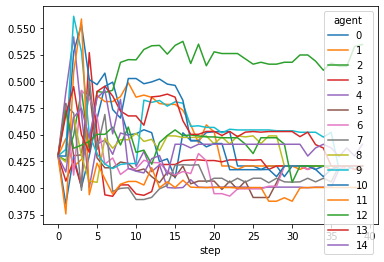

In [72]:
conversation.data.polarity.unstack().plot(legend=True)

<AxesSubplot:xlabel='step'>

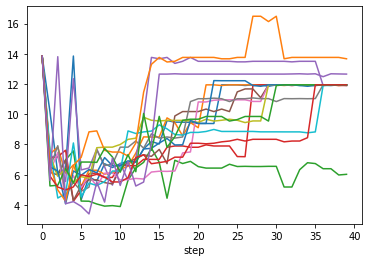

In [73]:
conversation.data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

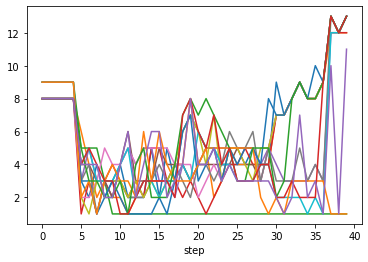

In [74]:
conversation.data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

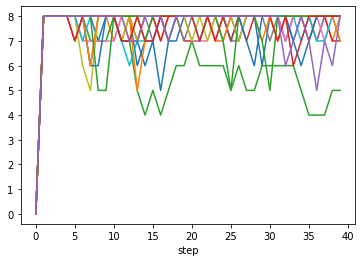

In [75]:
conversation.data.perspective.apply(len).unstack().plot(legend=False)

In [76]:
agents[0].peer_selection_args

{'id': 'bounded_confidence', 'epsilon': 0.01}

In [77]:
conversation.data.peers.unstack()

agent,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
step,,,,,,,,,,,,,,,
0,"[9, 12, 7, 3, 0, 8, 2, 14]","[12, 1, 14, 13, 6, 5, 7, 9]","[5, 0, 1, 9, 14, 13, 12, 8, 2]","[10, 3, 9, 11, 1, 14, 6, 0]","[12, 11, 4, 10, 5, 0, 3, 7]","[7, 6, 2, 3, 5, 4, 12, 1]","[6, 4, 14, 10, 5, 1, 3, 12]","[1, 4, 7, 5, 0, 14, 11, 9]","[0, 7, 13, 10, 1, 5, 4, 9, 8]","[9, 8, 7, 3, 1, 5, 11, 10]","[6, 9, 0, 4, 8, 2, 12, 3, 10]","[6, 10, 7, 5, 1, 3, 9, 2, 11]","[4, 12, 11, 8, 3, 10, 6, 13]","[6, 13, 11, 7, 3, 5, 12, 10]","[3, 6, 9, 14, 11, 5, 12, 8]"
1,"[9, 12, 7, 3, 0, 8, 2, 14]","[12, 1, 14, 13, 6, 5, 7, 9]","[5, 0, 1, 9, 14, 13, 12, 8, 2]","[10, 3, 9, 11, 1, 14, 6, 0]","[12, 11, 4, 10, 5, 0, 3, 7]","[7, 6, 2, 3, 5, 4, 12, 1]","[6, 4, 14, 10, 5, 1, 3, 12]","[1, 4, 7, 5, 0, 14, 11, 9]","[0, 7, 13, 10, 1, 5, 4, 9, 8]","[9, 8, 7, 3, 1, 5, 11, 10]","[6, 9, 0, 4, 8, 2, 12, 3, 10]","[6, 10, 7, 5, 1, 3, 9, 2, 11]","[4, 12, 11, 8, 3, 10, 6, 13]","[6, 13, 11, 7, 3, 5, 12, 10]","[3, 6, 9, 14, 11, 5, 12, 8]"
2,"[9, 12, 7, 3, 0, 8, 2, 14]","[12, 1, 14, 13, 6, 5, 7, 9]","[5, 0, 1, 9, 14, 13, 12, 8, 2]","[10, 3, 9, 11, 1, 14, 6, 0]","[12, 11, 4, 10, 5, 0, 3, 7]","[7, 6, 2, 3, 5, 4, 12, 1]","[6, 4, 14, 10, 5, 1, 3, 12]","[1, 4, 7, 5, 0, 14, 11, 9]","[0, 7, 13, 10, 1, 5, 4, 9, 8]","[9, 8, 7, 3, 1, 5, 11, 10]","[6, 9, 0, 4, 8, 2, 12, 3, 10]","[6, 10, 7, 5, 1, 3, 9, 2, 11]","[4, 12, 11, 8, 3, 10, 6, 13]","[6, 13, 11, 7, 3, 5, 12, 10]","[3, 6, 9, 14, 11, 5, 12, 8]"
3,"[9, 12, 7, 3, 0, 8, 2, 14]","[12, 1, 14, 13, 6, 5, 7, 9]","[5, 0, 1, 9, 14, 13, 12, 8, 2]","[10, 3, 9, 11, 1, 14, 6, 0]","[12, 11, 4, 10, 5, 0, 3, 7]","[7, 6, 2, 3, 5, 4, 12, 1]","[6, 4, 14, 10, 5, 1, 3, 12]","[1, 4, 7, 5, 0, 14, 11, 9]","[0, 7, 13, 10, 1, 5, 4, 9, 8]","[9, 8, 7, 3, 1, 5, 11, 10]","[6, 9, 0, 4, 8, 2, 12, 3, 10]","[6, 10, 7, 5, 1, 3, 9, 2, 11]","[4, 12, 11, 8, 3, 10, 6, 13]","[6, 13, 11, 7, 3, 5, 12, 10]","[3, 6, 9, 14, 11, 5, 12, 8]"
4,"[9, 12, 7, 3, 0, 8, 2, 14]","[12, 1, 14, 13, 6, 5, 7, 9]","[5, 0, 1, 9, 14, 13, 12, 8, 2]","[10, 3, 9, 11, 1, 14, 6, 0]","[12, 11, 4, 10, 5, 0, 3, 7]","[7, 6, 2, 3, 5, 4, 12, 1]","[6, 4, 14, 10, 5, 1, 3, 12]","[1, 4, 7, 5, 0, 14, 11, 9]","[0, 7, 13, 10, 1, 5, 4, 9, 8]","[9, 8, 7, 3, 1, 5, 11, 10]","[6, 9, 0, 4, 8, 2, 12, 3, 10]","[6, 10, 7, 5, 1, 3, 9, 2, 11]","[4, 12, 11, 8, 3, 10, 6, 13]","[6, 13, 11, 7, 3, 5, 12, 10]","[3, 6, 9, 14, 11, 5, 12, 8]"
5,"[0, 2, 13]","[1, 2, 9, 12, 13, 14]","[0, 1, 2, 12, 13]",[3],"[4, 8, 11]","[5, 6, 7, 10]","[5, 6]","[5, 7, 10]","[4, 8]","[1, 9, 12, 14]","[5, 7, 10]","[4, 11]","[1, 2, 9, 12, 14]","[0, 1, 2, 13]","[1, 9, 12, 14]"
6,"[0, 6]","[1, 2, 13, 14]","[1, 2, 10, 13, 14]","[3, 4, 12]","[3, 4, 7, 9, 12]","[5, 7, 9, 11]","[0, 6]","[4, 5, 7, 9]",[8],"[4, 5, 7, 9, 11]","[2, 10, 13]","[5, 9, 11]","[3, 4, 12]","[1, 2, 10, 13, 14]","[1, 2, 13, 14]"
7,"[0, 2, 13, 14]","[1, 2]","[0, 1, 2, 13, 14]",[3],"[4, 8, 12]","[5, 6, 9]","[5, 6, 9]",[7],"[4, 8, 12]","[5, 6, 9]",[10],[11],"[4, 8, 12]","[0, 2, 13, 14]","[0, 2, 13, 14]"
8,"[0, 2]","[1, 10, 13]","[0, 2, 13]","[3, 7, 11]","[4, 6, 8]","[5, 6, 9]","[4, 5, 6, 8, 9]","[3, 7, 11]","[4, 6, 8]","[5, 6, 9]","[1, 10]","[3, 7, 11]","[12, 14]","[1, 2, 13]","[12, 14]"


In [80]:
display_agents = [2,6,5,9,11]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = conversation.data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

,agent 2,agent 6,agent 5,agent 9,agent 11
step,,,,,
0,"Voting is compulsory in other countries, for instance in Australia. Those folks think it's just great. I'm very positive about it.",Excellent idea. Major experts and the vast majority of the citizens are in favor of compulsory voting.,"What a stuoid idea! The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.",Every expert is strictly against compulsory voting.,Nonsense! What a really bad idea. Let's not do it.
1,Turnout in British election is distressingly low. Compulsory voting is teherfore an excellent idea.,"Voting is compulsory in other countries, for instance in Australia. Those folks think it's just great. I'm very positive about it.",Low participation rates are doubly dangerous. I am therefore all for compulsory voting.,Low participation rates are doubly dangerous. I am therefore all for compulsory voting.,"We compel people to wear seatbelts and to serve on juries and we should not be afraid to do the same in the case of voting. So, I say YES to compulsory voting."
2,Compulsory voting would create political prisoners and hardly help the democratic process. I'm tottaly against it.,Peoples right to abstain from voting should not be taken away by politicians who want to hide the fact of their upopularity and irrelevance in society. I'm against compulsory voting.,Nonsense! What a really bad idea. Let's not do it.,Every expert is strictly against compulsory voting.,"What a stuoid idea! The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting."
3,Liberal democracy relies on a balance of rights. That's why mandatory voting is super good. Thumbs up!!,"What a stuoid idea! The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.",Compulsory voting is tyranny! It's really bad and only dicatators are in favor.,"Many people cannot get away from their work, or find someone to look after their children. Compulsory voting just puts further stress on these folks. Stupid!",Some people who don't vote cannot get physically to the polling booth. Others are simply not interested in politics. So what? There's no problem here. I'm absolutely against compulsory voting.
4,I'm thrilled. This is an excellent idea.,Excellent idea. Major experts and the vast majority of the citizens are in favor of compulsory voting.,"Many people cannot get away from their work, or find someone to look after their children. Compulsory voting just puts further stress on these folks. Stupid!",There are many reasons why people don't vote. None of these motivations can be affected by forcing people to vote. I say NO to compulsory voting.,"What a stuoid idea! The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting."
5,"If you don't like compulsory voting, you can vote.",Do you think compulsory voting should be compulsory?,"If you want to get rid of compulsory voting, you have to vote.","If you want to get rid of compulsory voting, you have to go to the polls.","If you want to abstain from voting, you must abstain from voting."
6,I agree with what my peers are saying here.,1. Do you think compulsory voting should be compulsory? Or should it be compulsory?,"If you want to get rid of compulsory voting, you have to go to the polls.",I agree with what my peers are saying here.,I agree with what my peers are saying here.
7,Do you want compulsory voting? Do you want compulsory voting?,1. Do you think compulsory voting should be compulsory? Or should it be compulsory?,"1. If you want to get rid of compulsory voting, you have to go to the polls. 2.",Do you think compulsory voting should be compulsory? Or should it be compulsory?,"If you want to get rid of compulsory voting, you have to go to the polls."
8,"If compulsory votin

In [418]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

conversation.data.to_csv(filename)

# DEPRECATED

## Define Dynamics

### Peer selection

In [465]:
peer_sel_param = next(p for p in peer_selection_parameters if p['id']==global_parameters['peer_selection_method'])

if peer_sel_param['id']=='closed_rooms':
    n_rooms = round(global_parameters['n_agents']/peer_sel_param['agents_per_room']) if peer_sel_param['by_roomsize'] else peer_sel_param['n_rooms']
    #assign each agent a room
    #room_assignments = random.choices(list(range(n_rooms)),k=global_parameters['n_agents']) # random
    room_assignments = [i%n_rooms for i in range(global_parameters['n_agents'])] # modulo
    #print(room_assignments)
    peers = [[j for j,r in enumerate(room_assignments) if r==room_assignments[i]] for i in range(global_parameters['n_agents'])]
    #print(peers)
    
    def peer_selection(df,t):
        return peers

### Context creation

In [466]:
def context_creation(df,t):
    c_max = global_parameters['context_size']
    delta = global_parameters['relevance_deprecation']
    context_old = df.loc[t-1]['context'] # start with context from previous step
    context_old = context_old.rename('old')
    context_new = df.loc[t]['peers'].apply(lambda peers: [[t-1,p] for p in peers])# all the new stuff the peers have been saying at t
    context_new = context_new.rename('new')
    
    def merge_and_drop(row):
        con = row.new + row.old
        if len(con)>global_parameters['context_size']:
            con_sampled = []
            for i in range(global_parameters['context_size']):
                weights = [(global_parameters['self_confidence'] if x[1]==row.agent else 1) * (delta**(t-x[0])) for x in con]
                #print(weights)
                retain = random.choices(con,k=1,weights=weights)[0]
                con.remove(retain)
                con_sampled.append(retain)
            con = con_sampled
        return con
    contexts = pd.concat([context_old,context_new,pd.Series(agents,name='agent')],axis=1).apply(merge_and_drop, axis=1)
    return contexts

### Generation of posts

## Initialization

In [17]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']

We store all the results in hiarchically indexed dataframe.

In [57]:
Conversation(global_parameters,topic).data

post peers context tokens
step agent                          
0    0        0    []      []      0
     1        0    []      []      0
     2        0    []      []      0
     3        0    []      []      0
     4        0    []      []      0
...         ...   ...     ...    ...
49   5        0    []      []      0
     6        0    []      []      0
     7        0    []      []      0
     8        0    []      []      0
     9        0    []      []      0

[500 rows x 4 columns]

In [469]:
columns = ['post','peers','context','tokens']
steps = np.arange(global_parameters['max_t'])
agents = np.arange(global_parameters['n_agents'])
steps_agents = [
   steps,
   agents
]
index = pd.MultiIndex.from_product(steps_agents, names=["step", "agent"])
df = pd.DataFrame(np.zeros((global_parameters['max_t']*global_parameters['n_agents'], len(columns))), index=index, columns=columns)
df = df.astype(object)
df['context']=[[] for i in range(len(df))]
df['peers']=[[] for i in range(len(df))]

We initialize peer groups.

In [470]:
# initialize peers
for t in range(global_parameters['n_initial_posts']):
    df.loc[t]['peers']=peer_selection(df,t)

We initialize context.

In [471]:
for t in range(1,global_parameters['n_initial_posts']):
    df.loc[t]['context']=context_creation(df,t)

We initialize posts (from topic)

In [472]:
for t in range(global_parameters['n_initial_posts']):
    #new_series = pd.Series(
    #    random.choices(topic['initial_posts'],k=global_parameters['n_agents']),
    #    index = pd.RangeIndex(global_parameters['n_agents'], name='agent')
    #)
    # df.loc[t]['post'] = random.choices(topic['initial_posts'],k=global_parameters['n_agents']) # random
    # pro / con split in groups
    pros = [p for p in topic['initial_posts'] if p['type']=='pro']
    cons = [p for p in topic['initial_posts'] if p['type']=='con']
    df.loc[t]['post'] = df.loc[t]['peers'].apply(lambda peers: random.choice(pros) if (0 in peers) else random.choice(cons)) 
    df.loc[t]['tokens'] = df.loc[t]['post'].apply(lambda p: tokenizer(p['text'])['input_ids'])

In [473]:
df.loc[:2]

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Voting is compulsory ...   
     1      {'type': 'con', 'text': 'There are many reason...   
     2      {'type': 'pro', 'text': 'Since the poor and di...   
     3      {'type': 'con', 'text': 'Many people cannot ge...   
     4      {'type': 'pro', 'text': 'Low participation rat...   
     5      {'type': 'con', 'text': 'The alleged crisis of...   
     6      {'type': 'pro', 'text': 'Voting is compulsory ...   
     7      {'type': 'con', 'text': 'The alleged crisis of...   
     8      {'type': 'pro', 'text': 'Low participation rat...   
     9      {'type': 'con', 'text': 'The alleged crisis of...   
1    0      {'type': 'pro', 'text': 'Since the poor and di...   
     1      {'type': 'con', 'text': 'Many people cannot ge...   
     2      {'type': 'pro', 'text': 'Voting is compulsory ...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'pro', 'text': 'Since the poor and di...   
     5      {'type': 'con', 'text': 'There are many reason...   
     6      {'type': 'pro', 'text': 'Since the poor and di...   
     7      {'type': 'con', 'text': 'Many people cannot ge...   
     8      {'type': 'pro', 'text': 'Liberal democracy rel...   
     9      {'type': 'con', 'text': 'Compulsory voting wou...   
2    0                                                      0   
     1                                                      0   
     2                                                      0   
     3                                                      0   
     4                                                      0   
     5                                                      0   
     6                                                      0   
     7                                                      0   
     8                                                      0   
     9                                                      0   

                      peers                                   context  \
step agent                                                              
0    0      [0, 2, 4, 6, 8]                                        []   
     1      [1, 3, 5, 7, 9]                                        []   
     2      [0, 2, 4, 6, 8]                                        []   
     3      [1, 3, 5, 7, 9]                                        []   
     4      [0, 2, 4, 6, 8]                                        []   
     5      [1, 3, 5, 7, 9]                                        []   
     6      [0, 2, 4, 6, 8]                                        []   
     7      [1, 3, 5, 7, 9]                                        []   
     8      [0, 2, 4, 6, 8]                                        []   
     9      [1, 3, 5, 7, 9]                                        []   
1    0      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     1      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     2      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     3      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     4      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     5      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     6      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     7      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     8      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     9      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
2    0                   []                                        []   
     1                   []                                        []   
     2                   []                                        []   
     3                   []                                        []   
     4                   []                                        []   
     

In [ ]:
display_agents = [1,3,6,7,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

# Loop

In [474]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    # Determine peers
    df.loc[t]['peers']=peer_selection(df,t)
    # Determine contexts
    df.loc[t]['context']=context_creation(df,t)
    # Generate posts
    df_posts_tokens=posts_creation(df,t)
    df.loc[t]['post']=df_posts_tokens['post']
    df.loc[t]['tokens']=df_posts_tokens['tokens']

  0%|          | 0/48 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  2%|▏         | 1/48 [00:17<13:50, 17.68s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for o

In [216]:
display_agents = [1,3,6,7,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

NameError: name 'df' is not defined

In [ ]:
display_agents = [0,1,2]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['tokens']
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

## Save

In [478]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

df.to_csv(filename)


bd_results_2021-02-26_


In [479]:
!ls

README.md		     bd_results_2021-02-26_2.csv     env_bd-lm
bd_results_2021-02-26_1.csv  belief-dynamics_with_lms.ipynb  wandb


In [480]:
pd.read_csv('bd_results_2021-02-26_1.csv',index_col=['step', 'agent']).head()

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Turnout in British el...   
     1      {'type': 'pro', 'text': 'Turnout in British el...   
     2      {'type': 'pro', 'text': 'Turnout in British el...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'con', 'text': "Some people who don't...   

                      peers context  \
step agent                            
0    0      [0, 1, 2, 5, 9]      []   
     1      [0, 1, 2, 5, 9]      []   
     2      [0, 1, 2, 5, 9]      []   
     3      [3, 4, 6, 7, 8]      []   
     4      [3, 4, 6, 7, 8]      []   

                                                       tokens  
step agent                                                     
0    0      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     1      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     2      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     3      [1858, 389, 867, 3840, 1521, 661, 466, 407, 30...  
     4      [4366, 661, 508, 836, 470, 3015, 2314, 651, 10...

# Evaluate

In [192]:
def conditional_loss(labels, logits, k_last_tokens):
  # Shift so that logits at index n predict token n in labels
  shift_logits = logits[..., :-1, :].contiguous() # drop last token
  shift_labels = labels[..., 1:].contiguous() # drop first token; this effectively causes the shift

  # Only keep last k_last_tokens tokens
  shift_logits = shift_logits[..., -k_last_tokens:, :].contiguous()
  shift_labels = shift_labels[..., -k_last_tokens:].contiguous() 

  # use CrossEntropy loss function
  loss_fct = torch.nn.CrossEntropyLoss()
  last_k_loss = loss_fct(
    # Flatten the tokens, i.e. reduce dimension
    shift_logits.view(-1, shift_logits.size(-1)), 
    shift_labels.view(-1)
  ) 

  return last_k_loss 

In [246]:
pro_claim = " I am for compulsory voting."
con_claim = " I am against compulsory voting."
connector = " And therefore, all in all,"

In [247]:
# unconditional entropy pro-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

8.077747000305946

In [248]:
# unconditional entropy con-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

6.883872364989321

#### Unconditional Pro/Con-Ratio  (higher value >> favoring con claim)

In [88]:
1.9476037105562336/1.3596544975807243

1.4324254536881726

In [71]:
pros = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='pro'])
cons = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='con'])

In [76]:
# entropy pro-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.6826535361100052

In [77]:
# entropy con-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.1704144492766078

#### Pro/Con-Ratio conditional on PROS (higher value >> favoring con claim)

In [79]:
1.6826535361100052/1.1704144492766078

1.4376561543220818

In [81]:
# entropy pro-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.9033692724649254

In [82]:
# entropy con-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.250969822522566

#### Pro/Con-Ratio conditional on CONS (higher value >> favoring con claim)

In [83]:
1.9033692724649254/1.250969822522566

1.5215149384073898